# Exercise 2. Logistic Regression

In this exercise, we will implement **Logistic Regression** and get to see how
it works on data. Before starting on this programming exercise, we strongly recommend 
watching the video lectures and completing the review questions for the associated topics.
For details see **ex2.pdf**

We will implement a logistic regression class **```LogisticRegression```** and **```LogisticRegRegularizedPoly6```** using mathematical concepts and algorithms without using any ML library then in the following section we will use it in exercise 5 of the course.

The classes are split into multiple cells using **```jdc```** package so that notes can be written for learning and understanding. 
Complete implementation of the classes are under **```src/supervised/logistic_regression_non_vectorized_newton.py```** and
under **```src/supervised/logistic_regression_non_vectorized_newton_regularized_poly6.py```** module of this repository.

Following cell declares the class **```LogisticRegression```** with its basic attributes and common utility members.

In [84]:
import jdc
import math
import numpy as np
import matplotlib.pyplot as plt

In [85]:
class LogisticRegression(object):
    '''
    Logistic regression classifier, It is non regularized, 
    non vectorized version uses Newton Method to minimize.
    It can handle n feature variables. Hypothesis for the classifier
    is a linear line.
    
    Other than instructor's (Andrew Ng) coursera.org course lectures
    and notes you can get help at instructor's course website for 
    following implementation. Here is the link.
    http://openclassroom.stanford.edu/MainFolder/DocumentPage.php?course=MachineLearning&doc=exercises/ex4/ex4.html
    '''
    
    def __init__(self, datafname = ''):
        '''
        Initialize by reading the data file.
        
        Arguments:
          datafname (string): Full path of data file,
            a csv like file is expected where the last column
            should be output 'y' values.
        '''
        # Feature matrix, last column is y.
        self.data = np.loadtxt(datafname, delimiter=',')
        
        # Number of training samples
        self.m = self.data.shape[0]
        self.min_theta = None
        # Array to keep J(theta) for each iteration.
        self.costs = None
    
    
    def tail(self, no_lines=3):
        '''
        Show last few rows.
        
        Arguments:
          no_lines (int): Number of lines to show.
        '''
        if self.m >= no_lines:
          print(self.data[self.m - no_lines:self.m,], end='\n\n')
        else:
          print(self.data[:,:], end='\n\n')
    
    
    def plot_scatter(self, f1_idx=0, f2_idx=1, x_label='', y_label=''):
        '''
        Plot scatter graph.
        
        Arguments:
          f1_idx (int): Feature 1 index in the data file.
          f2_idx (int): Feature 2 index in the data file.
          x_label (string): X axis label on the graph.
          y_label (string): Y axis label on the graph.
        '''
        # Read when y = 1.
        pos = np.where(self.data[:,2] == 1)
        neg = np.where(self.data[:,2] == 0)
        
        # First plot classes.
        plt.title('Scatter Plot')
        plt.scatter(self.data[pos, f1_idx], self.data[pos, f2_idx],
                    color='blue', marker='+', label='Admitted')
        plt.scatter(self.data[neg, f1_idx], self.data[neg, f2_idx],
                    color='red', marker='o', label='Not Admitted')
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.legend()
        plt.show()
    
    
    def plot_decision_line(self, f1_idx=0, f2_idx=1, x_label='', y_label=''):
        '''
        Plot the two features and the decision line.
        
        Arguments:
          f1_idx (int): Feature 1 index in the data file.
          f2_idx (int): Feature 2 index in the data file.
          x_label (string): X axis label on the graph.
          y_label (string): Y axis label on the graph.
        '''
        # Read when y = 1.
        pos = np.where(self.data[:,2] == 1)
        neg = np.where(self.data[:,2] == 0)
        
        # First plot classes.
        plt.title('Decision Line Plot')
        plt.scatter(self.data[pos, f1_idx], self.data[pos, f2_idx],
                    color='blue', marker='+', label='Admitted')
        plt.scatter(self.data[neg, f1_idx], self.data[neg, f2_idx],
                    color='red', marker='o', label='Not Admitted')
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        
        # Plotting decision boundary is equivalent to plotting
        # transpose(theta)*x = 0  solving this equation gives
        # x2 = -(1/theta2) * (theta0 + (theta1 * x1))
        # Now we can figure out x1 and x2 for decision boundary.
        
        # Only need 2 points for a line, get f1s first.
        f1_points = [min(self.data[:, f1_idx]) - 2, 
                      max(self.data[:, f1_idx]) + 2];
    
        # Function calculates f2.
        def get_f2(f1): 
          return (-(1.0/self.min_theta[f2_idx + 1]) * 
                  (self.min_theta[0] + (self.min_theta[f1_idx + 1] * f1)))
        
        # Get f2s
        f2_points = [get_f2(f1) for f1 in f1_points]
        # Plot decision boundary.
        plt.plot(f1_points, f2_points, label='Decision Line')
        plt.legend(fontsize='x-small')
        plt.show()
    
    
    def plot_cost_curve(self):
        '''
        Plot cost curve. 'train' function must be
        called before calling this function.
        '''
        # Plot iterations and costs.
        plt.title('Cost Curve')
        plt.xlabel('Iterations')
        plt.ylabel(r'J($\theta$)')
        plt.plot([i for i in range(len(self.costs))], self.costs, marker='o')
        plt.show()
    
    
    def predict(self, feature_vect):
        '''
        Predict for the given feature vector.
        This function should be called after "train".
        
        Arguments:
          feature_vect (n x 1 float vector): Features vector.
        
        Return:
          (float): A predicted value.
        '''
        x = np.ones(shape=(feature_vect.shape[0] + 1, 1))
        x[1:,] = feature_vect[:,]
        return self._sigmoid(x, self.min_theta)
    
    
    def predict_label(self, X):
        '''
        Predict label for each test example in the 
        feature matrix, where 0 means False and 1 means
        True. 
        This function should be called after "train".
        
        Arguments:
          X (m x n float matrix): Test examples matrix.
        
        Return:
          (vector with values of 0, 1): Predicted labels
          for each test example in the matrix.
        '''
        labels = np.zeros((X.shape[0], 1), dtype=int)
        # Iterate over rows.
        for i, xi in enumerate(X):
          xi = np.reshape(xi, (len(xi), 1))
          prob = self.predict(xi)
          if prob >= 0.5:
            labels[i] = 1
        return labels
    
    
    def min_cost(self):
        '''
        Return min cost. It should be called after 'train' function.
    
        Return:
          (float): Min cost.
        '''
        return np.min(self.costs)

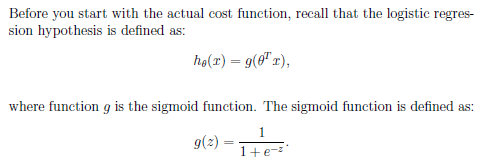

In [86]:
%%add_to LogisticRegression

def train(self, iter_min=7):
    '''
    Train from training data. Uses Newton Method to
    minimize theta values.

    Arguments:
      iter_min (int): Iterations to converge theta values
        by Newton Method default to 7.
    '''
    # Remove count of y from x.
    xcols = self.data.shape[1] - 1

    # Though input feature vectors are row vectors but
    # for the operational ease it is better to keep 
    # them as column vectors, that way it resembles
    # the notation of formula.
    
    # Remember x0 = 1 , is required by the algorithm.
    # So it is two dimensional array, notice the
    # shaped of the array, if you had 80 rows in
    # your input data it will become 80 columns
    # and first row always be 1s since x0 =1 i.e
    # 1   1  1  . .
    # a1  b1 c1 . .
    # a2  b2 c2 . .
    # .   .  .  . .
    # .   .  .  . .
    X = np.ones(shape=(xcols + 1, self.m))
    X[1:,:] = self.data[:,0:xcols].transpose()

    # y keeps last column of each feature vector
    # of input data, 0 or 1 such as (see last column)
    # a1, a2, a3, 1
    # b1, b2, b3, 0
    # c1, c2, c3, 0
    y = self.data[:, xcols]

    # Minimize theta values using Newton's method.
    self.min_theta, self.costs = \
      self._min_thetas_newton_method(X, y, iter_min)

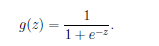

In [87]:
%%add_to LogisticRegression

def _sigmoid(self, xi, theta):
    '''
    Sigmoid function.

    Arguments:
      xi (n x 1 float vector): Feature values vector.
      theta (n x 1 float vector): Theta values vector.

    Return:
      (float): A sigmoid value.
    '''
    z = np.transpose(theta).dot(xi)
    return 1.0 / (1.0 + math.exp(-z))

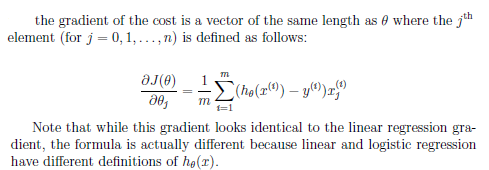

In [88]:
%%add_to LogisticRegression

def _gradient(self, X, y, theta):
    '''
    Compute gradient descent to learn theta values.

    Arguments:
      X (n x m float matrix): Feature values vectors, e.g.
        1   1  1  . .
        a1  b1 c1 . .
        a2  b2 c2 . .
        .   .  .  . .
        .   .  .  . .
        Notice dimension of feature vectors are by columns 
        NOT by rows.
      y (1d float array): Output of the features vectors in 
        the training data such as 0s or 1s.
      theta (n x 1 float vector): Theta values vector.

    Return:
      (n x 1 float vector): A gradient values vector, size of
        vector will match 'theta' vector.
    '''
    grad = np.zeros_like(theta)
    # Iterate over columns.
    for i, yi in enumerate(y):
      xi = X[:, [i]]
      h = self._sigmoid(xi, theta)
      grad += (h - yi) * xi
    return grad / self.m

In [89]:
%%add_to LogisticRegression

def _hessian(self, X, theta):
    '''
    Compute Hessian.

    Arguments:
      X (n x m float matrix): Feature values vectors, e.g.
        1   1  1  . .
        a1  b1 c1 . .
        a2  b2 c2 . .
        .   .  .  . .
        .   .  .  . .
        Notice dimension of feature vectors are by columns 
        NOT by rows.
      theta (n x 1 float vector): Theta values vector.

    Return:
      (n x n float matrix): The Hessian values matrix where
        size is 'X.rows x X.rows'.
    '''
    hessian = np.zeros(shape=(X.shape[0], X.shape[0]))
    # Iterate over columns.
    for i in range(X.shape[1]):
      xi = X[:, [i]]
      h = self._sigmoid(xi, theta)
      hessian += (h * (1 - h)) * (xi.dot(np.transpose(xi)))
    return hessian / self.m

In [90]:
%%add_to LogisticRegression

def _min_thetas_newton_method(self, X, y, iter_min):
    ''' 
    Minimize theta values using Newton Method.

    Arguments:
      X (n x m float matrix): Feature values vectors, e.g.
        1   1  1  . .
        a1  b1 c1 . .
        a2  b2 c2 . .
        .   .  .  . .
        .   .  .  . .
        Notice dimension of feature vectors are by columns 
        NOT by rows.
      y (1d float array): Output of the features vectors in 
        the training data such as 0s or 1s.
      iter_min (int): Iterations to converge theta values
        by Newton Method.

    Return:
      (1 x n float vector): The theta values vector.
      (float list): The cost value for each iteration.
    '''
    # Create a 2d array for the thetas.
    # Notice it is 1 column that has (features + 1) rows.
    theta = np.zeros(shape=(X.shape[0], 1))
    Jtheta = list()

    for i in range(iter_min):
      grads = self._gradient(X, y, theta)
      hessian = self._hessian(X, theta)
      theta -= (np.linalg.pinv(hessian).dot(grads) )
      Jtheta.append(self._cost(X, y, theta))
    return theta, Jtheta

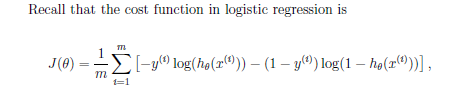

In [91]:
%%add_to LogisticRegression

def _cost(self, X, y, theta):
    '''
    Compute cost of the hypothesis for the given
    theta values.

    Arguments:
      X (n x m float matrix): Feature values vectors, e.g.
        1   1  1  . .
        a1  b1 c1 . .
        a2  b2 c2 . .
        .   .  .  . .
        .   .  .  . .
        Notice dimension of feature vectors are by columns 
        NOT by rows.
      y (1d float array): Output of the features vectors in 
        the training data such as 0s or 1s.
      theta (n x 1 float vector): Theta values vector.

    Return:
      (float): The cost J for the given theta values vector.
    '''
    likelihood = 0.0
    # Iterate over columns.
    for i in range(X.shape[1]):
      h = self._sigmoid(X[:, [i]], theta)
      likelihood += ((y[i] * math.log(h)) + ((1.0 - y[i]) * math.log(1.0 - h)))
    # J(theta) is cost of the hypothesis.
    return -(likelihood / (self.m))

##### Following cell declares the class **```LogisticRegRegularizedPoly6```** with its basic attributes and common utility members. Complete under **```src/supervised/logistic_regression_non_vectorized_newton_regularized_poly6.py```** module of this repository.

In [92]:
class LogisticRegRegularizedPoly6(object):
    '''
    Logistic regression regularized non vectorized 
    classifier, polynomial 6 hypothesis, uses Newton
    Method to minimize.
    
    It can handle only two n=2 feature variables,
    hypothesis for the classifier is monomials
    of power 6 (polynomial terms), such as
    1, v, u, u^2, uv, v^2, u^3...uv^5, v^6
    
    Other than instructor's (Andrew Ng) coursera.org course lectures
    and notes you can get help at instructor's course website for 
    following implementation. Here is the link.
    http://openclassroom.stanford.edu/MainFolder/DocumentPage.php?course=MachineLearning&doc=exercises/ex5/ex5.html
    '''
    
    def __init__(self, datafname = ''):
        '''
        Initialize by reading the data file.
        
        Arguments:
          datafname (string): Full path of data file,
            a csv like file is expected where the last column
            should be output 'y' values.
        '''
        # Feature matrix, last column is y.
        self.data = np.loadtxt(datafname, delimiter=',')
        
        # Number of training samples
        self.m = self.data.shape[0]
        self.min_theta = None
        # Array to keep J(theta) for each iteration.
        self.costs = None
    
    
    def tail(self, no_lines=3):
        '''
        Show last few rows.
        
        Arguments:
          no_lines (int): Number of lines to show.
        '''
        if self.m >= no_lines:
          print(self.data[self.m - no_lines:self.m,], end='\n\n')
        else:
          print(self.data[:, :], end='\n\n')
    
    
    def plot_scatter(self, f1_idx=0, f2_idx=1, x_label='', y_label=''):
        '''
        Plot scatter graph.
        
        Arguments:
          f1_idx (int): Feature 1 index in the data file.
          f2_idx (int): Feature 2 index in the data file.
          x_label (str) X axis label.
          y_label (str): Y axis label.
        '''
        # Read when y = 1.
        pos = np.where(self.data[:,2] == 1)
        neg = np.where(self.data[:,2] == 0)
        
        # First plot classes.
        plt.title('Scatter Plot')
        plt.scatter(self.data[pos, f1_idx], self.data[pos, f2_idx],
                    color='blue', marker='+', label='y=1')
        plt.scatter(self.data[neg, f1_idx], self.data[neg, f2_idx],
                    color='red', marker='o', label='y=0')
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.legend()
        plt.show()
    
    
    def plot_decision_line(self, lambda_label='0', f1_idx=0, f2_idx=1,
                         x_label='', y_label=''):
        '''
        Plot the two features and the decision line.
        
        Arguments:
          lambda_label (string): Title lambda value label.
          f1_idx (int): Feature 1 index in the data file.
          f2_idx (int): Feature 2 index in the data file.
          x_label (str) X axis label.
          y_label (str): Y axis label.
        '''
        # Read when y = 1.
        pos = np.where(self.data[:,2] == 1)
        neg = np.where(self.data[:,2] == 0)
        
        # First plot classes.
        plt.title('Decision Line Plot $\\lambda$ = ' + lambda_label,
                  fontsize=14)
        plt.scatter(self.data[pos, f1_idx], self.data[pos, f2_idx],
                    color='blue', marker='+', label='y=1')
        plt.scatter(self.data[neg, f1_idx], self.data[neg, f2_idx],
                    color='red', marker='o', label='y=0')
        
        # Plot decision boundary.
        # Define the ranges of the grid
        u = np.linspace(-1, 1.5, 200)
        v = np.linspace(-1, 1.5, 200)
        # Initialize space for the values to be plotted.
        z = np.zeros(shape=(len(u), len(v)))
        
        ## Evaluate z = theta*x over the grid.
        for i in range(len(u)):
          for j in range(len(v)):
            # Notice the order of j, i here.
            z[j, i] = self._z_value(u[i], v[j])
        
        # Plot z = 0 by specifying the range [0, 0]
        plt.contour(u, v, z, 2, colors='green')
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.legend()
        plt.show()
    
    
    def plot_cost_curve(self):
        '''
        Plot cost curve. 'train' function must be
        called before calling this function.
        '''
        # Plot iterations and costs.
        plt.title('Cost Curve')
        plt.xlabel('Iterations')
        plt.ylabel(r'J($\theta$)')
        plt.plot([i for i in range(len(self.costs))], self.costs, marker='o')
        plt.show()
    
    
    def predict(self, f1, f2):
        '''
        Predict for the given feature vector.
        This function should be called after "train".
        
        Arguments:
          f1 (float): Features 1.
          f2 (float): Features 2.
        
        Return:
          (float): A predicted value.
        '''
        poly6, cols = self._assign_feature_polynomial6(
          np.array([[f1]]), np.array([[f2]]))
        x = np.ones(shape=(1, cols + 1))
        x[:,1:] = poly6
        return self._sigmoid(np.transpose(x), self.min_theta)
    
    
    def predict_label(self, X):
        '''
        Predict label for each test example in the 
        feature matrix, where 0 means False and 1 means
        True. 
        This function should be called after "train".
        
        Arguments:
          X (m x n float matrix): Test examples matrix.
        
        Return:
          (vector with values of 0, 1): Predicted labels
          for each test example in the matrix.
        '''
        labels = np.zeros((X.shape[0], 1), dtype=int)
        # Iterate over rows.
        for i, xi in enumerate(X):
          prob = self.predict(xi[0], xi[1])
          if prob >= 0.5:
            labels[i] = 1
        return labels

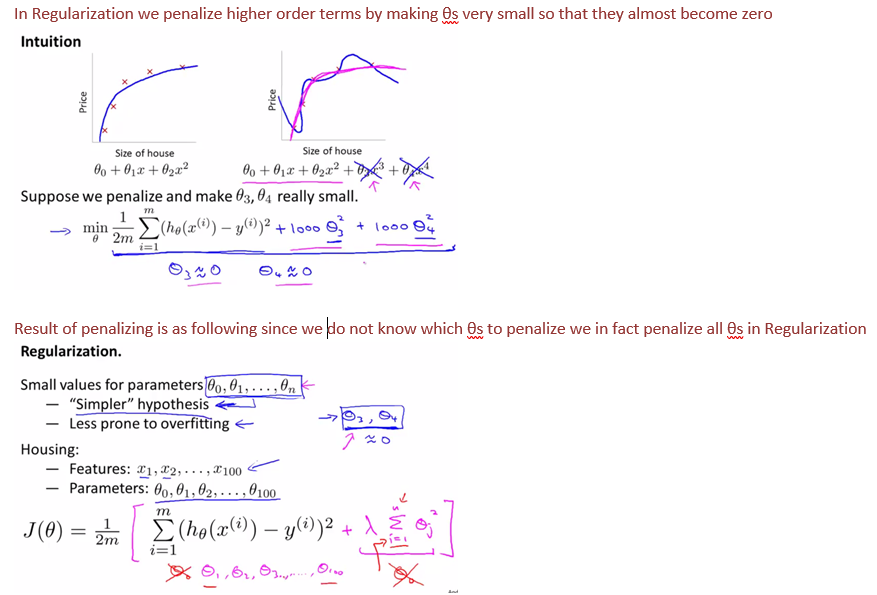

In [93]:
%%add_to LogisticRegRegularizedPoly6

def train(self, iter_min=15, lmda=0.0):
    '''
    Train from training data. Uses Newton Method to
    minimize theta values.

    Arguments:
      iter_min (int): Iterations to converge theta values
        by Newton Method default to 15.
      lmda (float): Lambda, the regularization parameter.
    '''
    # There are only two feature but we form
    # polynomial 6 which will have 28 features
    # for each vector.
    X_poly6, xcols = self._assign_feature_polynomial6(
      self.data[:, 0], self.data[:, 1])

    # Though input feature vectors are row vectors but
    # for the operational ease it is better to keep 
    # them as column vectors, that way it resembles
    # the notation of formula.
    
    # Remember x0 = 1 , is required by the algorithm.
    # So it is two dimensional array, notice the
    # shaped of the array, if you had 80 rows in
    # your input data it will become 80 columns
    # and first row always be 1s since x0 =1 i.e
    # 1   1  1  . .
    # a1  b1 c1 . .
    # a2  b2 c2 . .
    # .   .  .  . .
    # .   .  .  . .
    X = np.ones(shape=(xcols + 1, self.m))
    X[1:,:] = X_poly6[:, 0:xcols].transpose()

    # y keeps last column of each feature vector
    # of input data, 0 or 1 such as (see last column)
    # a1, a2, a3, 1
    # b1, b2, b3, 0
    # c1, c2, c3, 0
    y = self.data[:, self.data.shape[1] - 1]

    # Minimize theta values using Newton's method.
    self.min_theta, self.costs = \
      self._min_thetas_newton_method(X, y, iter_min, lmda)


In [94]:
%%add_to LogisticRegRegularizedPoly6

def _z_value(self, f1, f2):
    '''
    Calculate 'z' value for contour plot.

    Arguments:
      f1 (float): Features 1.
      f2 (float): Features 2.

    Return:
      (float): z value.
    '''
    poly6, cols = self._assign_feature_polynomial6(
      np.array([[f1]]), np.array([[f2]]))
    x = np.ones(shape=(1, cols + 1))
    x[:,1:] = poly6
    return x.dot(self.min_theta)

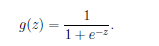

In [95]:
%%add_to LogisticRegRegularizedPoly6

def _sigmoid(self, xi, theta):
    '''
    Sigmoid function.

    Arguments:
      xi (n x 1 float vector): Feature values vector.
      theta (n x 1 float vector): Theta values vector.

    Return:
      (float): A sigmoid value.
    '''
    z = np.transpose(theta).dot(xi)
    return 1.0 / (1.0 + math.exp(-z))

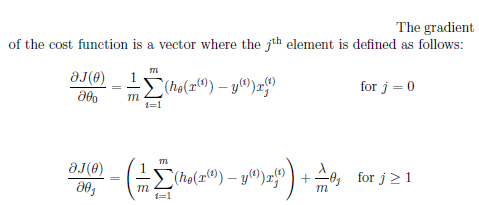

In [96]:
%%add_to LogisticRegRegularizedPoly6

def _gradient(self, X, y, theta):
    '''
    Compute gradient descent to learn theta values.

    Arguments:
      X (n x m float matrix): Feature values vectors, e.g.
        1   1  1  . .
        a1  b1 c1 . .
        a2  b2 c2 . .
        .   .  .  . .
        .   .  .  . .
        Notice dimension of feature vectors are by columns 
        NOT by rows.
      y (1d float array): Output of the features vectors in 
        the training data such as 0s or 1s.
      theta (n x 1 float vector): Theta values vector.

    Return:
      (n x 1 float vector): A gradient values vector, size of
        vector will match 'theta' vector.
    '''
    grad = np.zeros_like(theta)
    # Iterate over columns.
    for i, yi in enumerate(y):
      xi = X[:, [i]]
      h = self._sigmoid(xi, theta)
      grad += (h - yi) * xi
    return (grad / self.m)

In [97]:
%%add_to LogisticRegRegularizedPoly6

def _hessian(self, X, theta):
    '''
    Compute Hessian.

    Arguments:
      X (n x m float matrix): Feature values vectors, e.g.
        1   1  1  . .
        a1  b1 c1 . .
        a2  b2 c2 . .
        .   .  .  . .
        .   .  .  . .
        Notice dimension of feature vectors are by columns 
        NOT by rows.
      theta (n x 1 float vector): Theta values vector.

    Return:
      (n x n float matrix): The Hessian values matrix where
        size is 'X.rows x X.rows'.
    '''
    hessian = np.zeros(shape=(X.shape[0], X.shape[0]))
    # Iterate over columns.
    for i in range(X.shape[1]):
      xi = X[:, [i]]
      h = self._sigmoid(xi, theta)
      hessian += (h * (1 - h)) * (xi.dot(np.transpose(xi)))
    return hessian / self.m

In [98]:
%%add_to LogisticRegRegularizedPoly6

def _min_thetas_newton_method(self, X, y, iter_min, lmda):
    ''' 
    Minimize theta values using Newton Method.

    Arguments:
      X (n x m float matrix): Feature values vectors, e.g.
        1   1  1  . .
        a1  b1 c1 . .
        a2  b2 c2 . .
        .   .  .  . .
        .   .  .  . .
        Notice dimension of feature vectors are by columns 
        NOT by rows.
      y (1d float array): Output of the features vectors in 
        the training data such as 0s or 1s.
      iter_min (int): Iterations to converge theta values
        by Newton Method.
      lmda (float): Lambda, the regularization parameter.

    Return:
      (1 x n float vector): The theta values vector.
      (float list): The cost value for each iteration.
    '''
    # Create a 2d array for the thetas.
    # Notice it is 1 column that has (features + 1) rows.
    theta = np.zeros(shape=(X.shape[0], 1))
    Jtheta = list()
    
    # Grads regularization, same shape as theta.
    grads_reg = np.zeros(shape=(X.shape[0], 1))
    # Hessian regularization, shape as below hessian 
    # variable i.e n x n.
    hessian_reg = (lmda / self.m) * np.identity(X.shape[0])
    hessian_reg[0] = 0

    for i in range(iter_min):
      grads_reg = (lmda / self.m) * theta
      # Set extra term.
      grads_reg[0] = 0
      grads = self._gradient(X, y, theta) + grads_reg
      hessian = self._hessian(X, theta) + hessian_reg
      theta -= (np.linalg.pinv(hessian).dot(grads) )

      Jtheta_reg = ((lmda / (2 * self.m)) * (np.sum(theta ** 2)))
      Jtheta.append(self._cost(X, y, theta) + Jtheta_reg)
    return theta, Jtheta

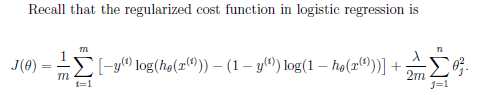

In [99]:
%%add_to LogisticRegRegularizedPoly6

def _cost(self, X, y, theta):
    '''
    Compute cost of the hypothesis for the given
    theta values.

    Arguments:
      X (n x m float matrix): Feature values vectors, e.g.
        1   1  1  . .
        a1  b1 c1 . .
        a2  b2 c2 . .
        .   .  .  . .
        .   .  .  . .
        Notice dimension of feature vectors are by columns 
        NOT by rows.
      y (1d float array): Output of the features vectors in 
        the training data such as 0s or 1s.
      theta (n x 1 float vector): Theta values vector.

    Return:
      (float): The cost J for the given theta values vector.
    '''
    likelihood = 0.0
    # Iterate over columns.
    for i in range(X.shape[1]):
      h = self._sigmoid(X[:, [i]], theta)
      likelihood += ((y[i] * math.log(h)) + ((1.0 - y[i]) * math.log(1.0 - h)))
    # J(theta) is cost of the hypothesis.
    return -(likelihood / (self.m))

In [100]:
%%add_to LogisticRegRegularizedPoly6

def _assign_feature_polynomial6(self, f1, f2):
    '''
    Compute 6th degree polynomial.
    We have only two features f1, f2 in data file, we will assign
    x to be all monomials (meaning polynomial terms) of f1 and f2
    up to the sixth power which makes a 28-feature vector. i.e.

    x = 1, f1, f2, f1^2, f1f2, f2^2, f1^3...f1f2^5, f2^6

    Arguments:
      f1 (n x 1 float vector): Feature 1 values vector.
      f2 (n x 1 float vector): Feature 2 values vector.

    Return:
      (1 x 28 float vector): 28-feature vectors.
      (int): Number of columns.
    '''
    xcols = 28
    degree = 6
    out = np.ones(shape=(f1.shape[0], xcols))
    col = 0

    for i in range(0, degree + 1):
      for j in range(0, i + 1):
        out[:, col] = (f1 ** (i - j)) * (f2 ** j)
        col += 1
    return out, xcols

### Course Exercise No 2 'Logistic Regression'. For detailed description of the exercise see "ex2.pdf"
#### This exercise uses the class "LogisticRegression" we implemented above.
#### Solution of whole excercise is available in a single class definitions see ```src/exercises/coursera/ex2.py```

## Execute parts of the exercise of non regularized algorithm.

### Part 1: Plotting

In [101]:
import warnings
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-height: 100% ! important; }</style>"))
warnings.filterwarnings("ignore")

print('Loading data...')
datafname = 'data/ex2data1.dat'
lgr = LogisticRegression(datafname)

Loading data...


Plotting data with + indicating (y = 1) examples and o indicating (y = 0) examples.


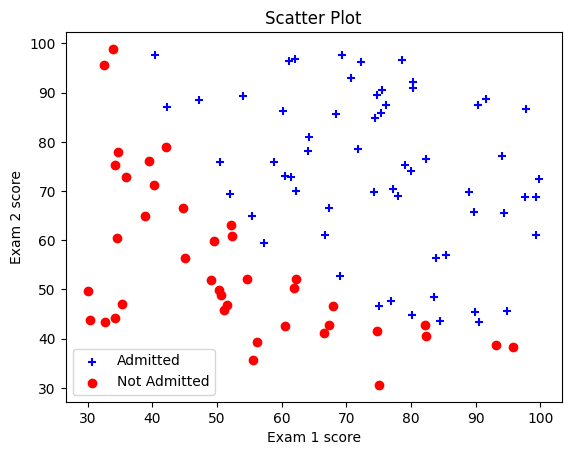

In [102]:
print('Plotting data with + indicating (y = 1) examples and o ' 'indicating (y = 0) examples.')
lgr.plot_scatter(0, 1, 'Exam 1 score', y_label='Exam 2 score')

### Part 2, 3: Compute Cost, Gradient Descent and Optimize

Important Note:- Please note ```fminunc``` is not used for optimization as suggested in exercise rather algorithm uses implementation of gradient descent (see lectures). If you are interested how to use ```fmin_XX``` functions for optimization please see class ```LogisticRegRegularizedMulticlass``` under ```src/suprvised/logistic_regression_regularized_multiclass```.

In [103]:
lgr.train()
print('Cost {} test passed'.format(lgr.min_cost()))
print('Thetas\n {}'.format(lgr.min_theta))

Cost 0.2034977015894401 test passed
Thetas
 [[-25.16133257]
 [  0.20623171]
 [  0.20147159]]


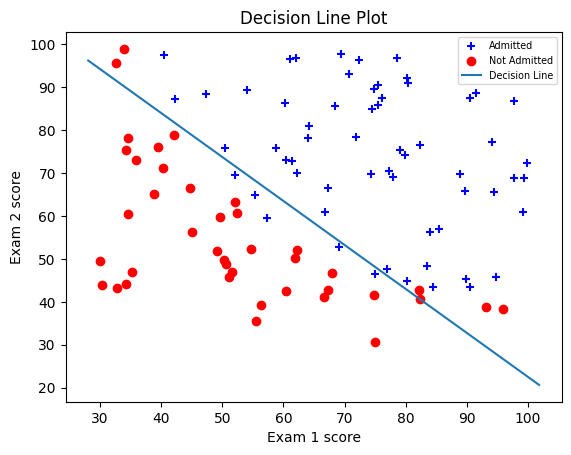

In [104]:
lgr.plot_decision_line(0, 1, 'Exam 1 score', y_label='Exam 2 score')

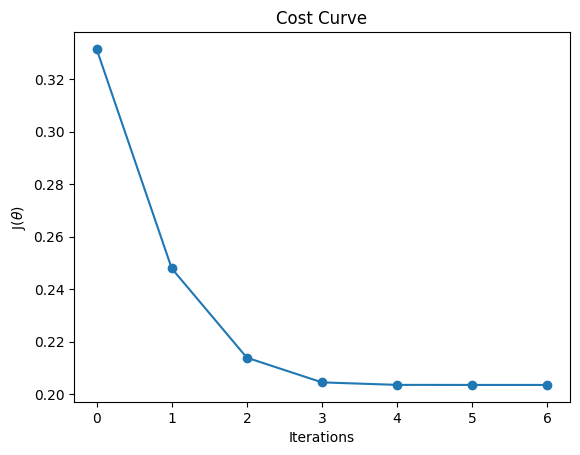

In [105]:
lgr.plot_cost_curve()

### Part 4: Predict and Accuracies

In [106]:
predict = lgr.predict(np.array([[45.0], [85.0]]))
print('For a student with scores 45 and 85, ' + 
      'we predict an admission probability of {} test passed.'.format(predict))

For a student with scores 45 and 85, we predict an admission probability of 0.7762906811489204 test passed.


In [107]:
print('Computing accuracy...')
data = np.loadtxt(datafname, delimiter=',')
cols = data.shape[1] - 1
X = data[:,:cols]
y = data[:,cols:]

pred = lgr.predict_label(X)
print('Predicted accuracy {}%.'.format(np.mean(pred == y) * 100))

Computing accuracy...
Predicted accuracy 89.0%.


## Regularized Logistic Regression

Important Note:- Please note ```fminunc``` is not used for optimization as suggested in exercise rather algorithm uses implementation of gradient descent (see lectures). If you are interested how to use ```fmin_XX``` functions for optimization please see class ```LogisticRegRegularizedMulticlass``` under ```src/suprvised/logistic_regression_regularized_multiclass```.

### Part 1, 2: Load data and map features to polynomial 6

In [108]:
datafname = 'data/ex2data2.dat'
plot_scatter = True

Plotting data scatter...


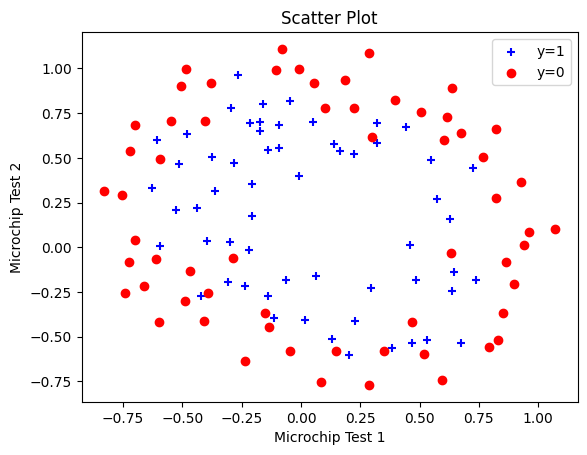


Training with lambda 0...
Plotting decision line...


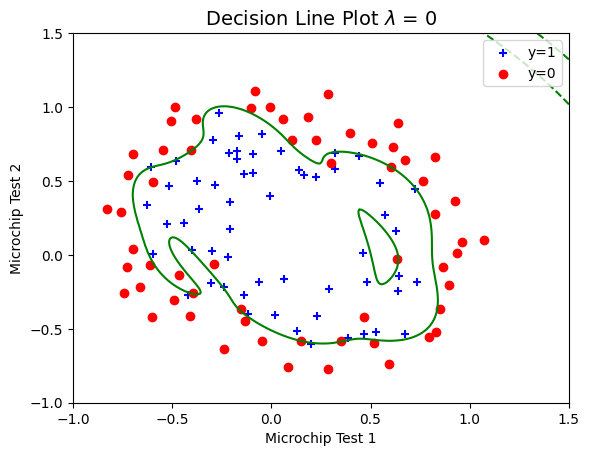

Computing accuracy...
Predicted accuracy 88.98305084745762%.

Training with lambda 1...
Plotting decision line...


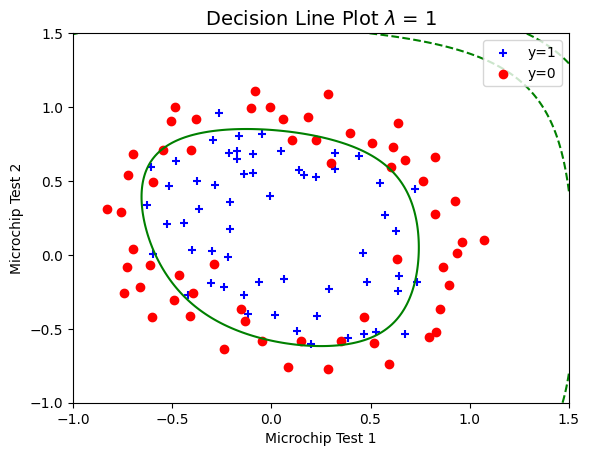

Computing accuracy...
Predicted accuracy 83.05084745762711%.

Training with lambda 10...
Plotting decision line...


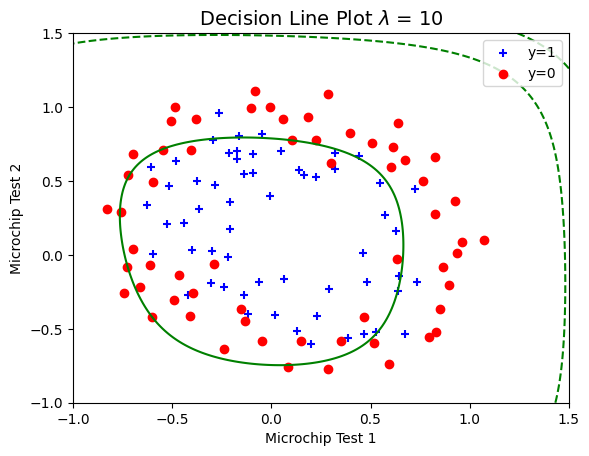

Computing accuracy...
Predicted accuracy 74.57627118644068%.

Training with lambda 100...
Plotting decision line...


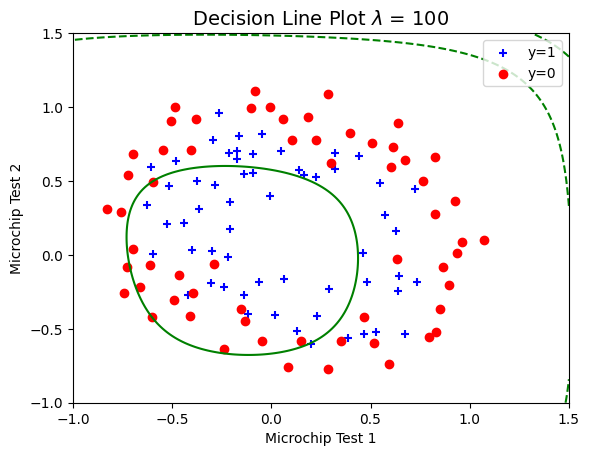

Computing accuracy...
Predicted accuracy 61.016949152542374%.


In [109]:
lmda = [0, 1, 10, 100]
for l in lmda:
    lgrr = LogisticRegRegularizedPoly6(datafname)
    
    if plot_scatter:
        print('Plotting data scatter...')
        lgrr.plot_scatter(0, 1, 'Microchip Test 1', 'Microchip Test 2')
        plot_scatter = False
    
    print('\nTraining with lambda {}...'.format(l))
    lgrr.train(15, l)
    
    print('Plotting decision line...')
    lgrr.plot_decision_line(str(l), 0, 1, 'Microchip Test 1', 'Microchip Test 2')
    
    print('Computing accuracy...')
    data = np.loadtxt(datafname, delimiter=',')
    cols = data.shape[1] - 1
    X = data[:,:cols]
    y = data[:,cols:]
    pred = lgrr.predict_label(X)
    print('Predicted accuracy {}%.'.format(np.mean(pred == y) * 100))